# SOAI Lab: Smart Home Energy Consumption Prediction


# INSTALL DEPENDENCIES


## Part 0 : Import used libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

## Part 1 : Understand the data and Exploring it

### 1.1. Load the Training Data :
- The first step is to load the training data into the system. This is typically done using a data

In [2]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

### 1.2. Inspect the Training Data
- Inspect the training data to understand the distribution of the target variable and the features. This step is crucial

In [3]:
# Display the first few rows of the training data
print(train_data)

# Display information about the training data
print(train_data.info())

# Display summary statistics of the training data
print(train_data.describe())

# Check for missing values in the training data
print(train_data.isnull().sum())

                  DateTime  EnergyConsumption(kWh)
0      2015-11-01 00:00:00                      15
1      2015-11-01 01:00:00                      13
2      2015-11-01 02:00:00                      10
3      2015-11-01 03:00:00                       7
4      2015-11-01 04:00:00                       9
...                    ...                     ...
10244  2016-12-31 20:00:00                      37
10245  2016-12-31 21:00:00                      32
10246  2016-12-31 22:00:00                      33
10247  2016-12-31 23:00:00                      32
10248  2017-01-01 00:00:00                      27

[10249 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.

### 1.3. Extracting Meaningful Informations
- Extracting temporal features form Datetime

In [4]:
# Convert DateTime to pandas datetime object
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

In [5]:
# Extract features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
train_data['quarter'] = train_data['DateTime'].dt.quarter
train_data['is_weekend'] = train_data['day_of_week'] >= 5
train_data['month'] = train_data['DateTime'].dt.month
train_data['year'] = train_data['DateTime'].dt.year
train_data['day_of_year'] = train_data['DateTime'].dt.dayofyear
train_data['day_of_month'] = train_data['DateTime'].dt.day
train_data['week_of_year'] = train_data['DateTime'].dt.isocalendar().week

### 1.4. Visualising Trends
- Visualising trends is an important aspect of data analysis. It helps to identify patterns, relationships
and anomalies in the data. There are several types of visualisations that can be used to
visualise trends

#### 1.4.1. Hourly Trends

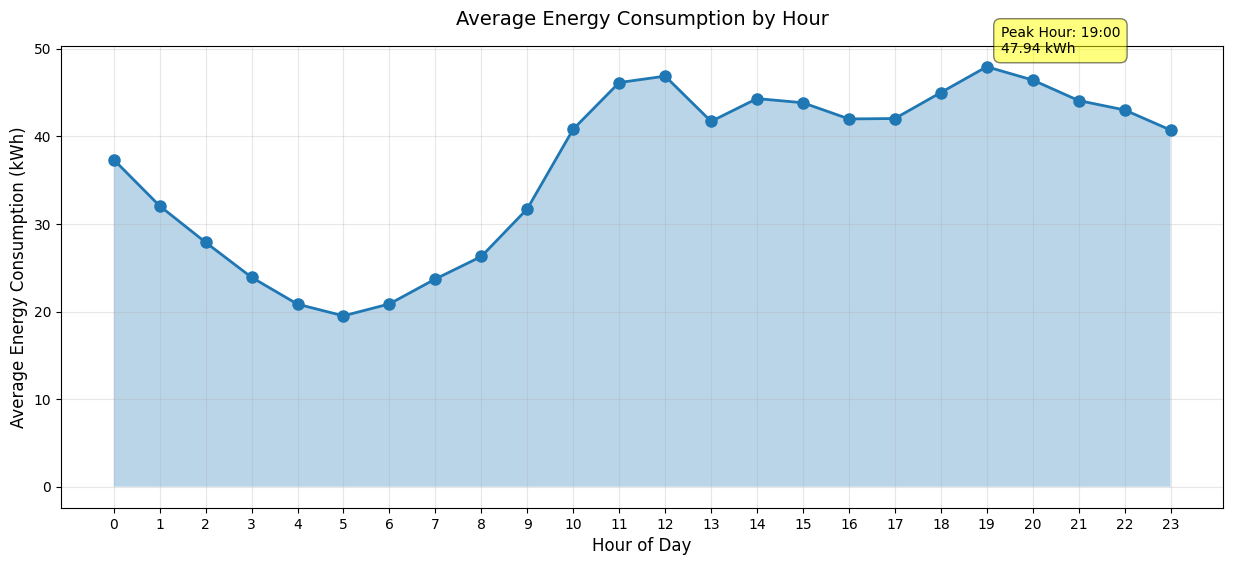

In [6]:
plt.figure(figsize=(15, 6))
hourly_avg = train_data.groupby('hour')['EnergyConsumption(kWh)'].mean()

plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
plt.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
plt.title('Average Energy Consumption by Hour', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Add peak hours annotation
peak_hour = hourly_avg.idxmax()
plt.annotate(f'Peak Hour: {peak_hour}:00\n{hourly_avg[peak_hour]:.2f} kWh', 
            xy=(peak_hour, hourly_avg[peak_hour]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

#### 1.4.2. Daily Trends

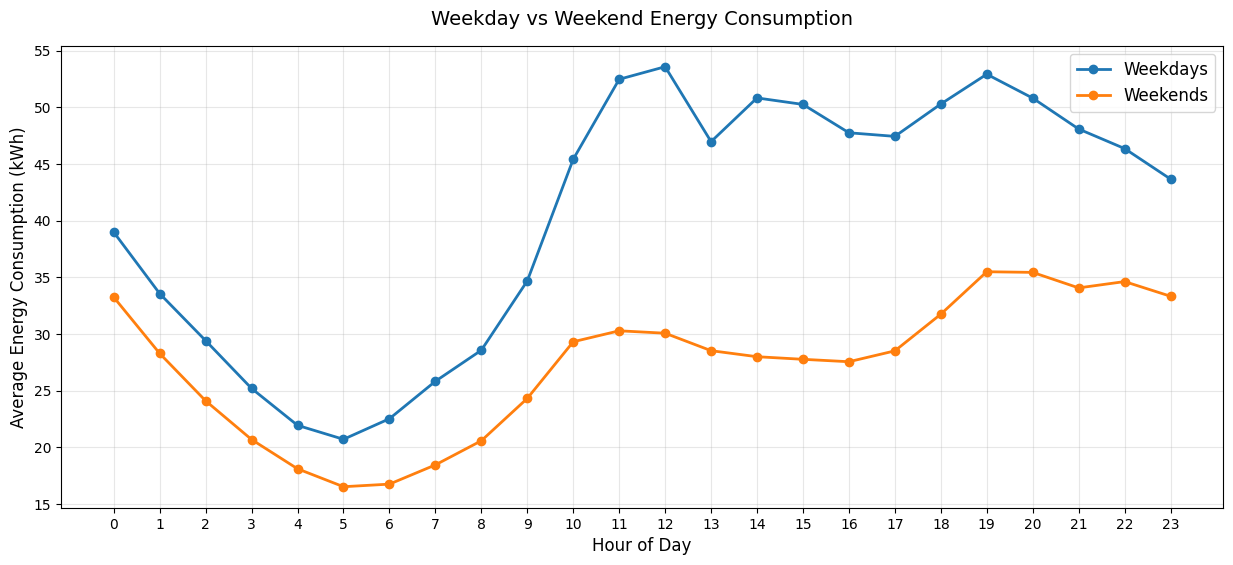

In [7]:
plt.figure(figsize=(15, 6))

# Calculate averages
weekday_hourly = train_data[~train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()
weekend_hourly = train_data[train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()

# Plot both lines
plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekdays', marker='o', linewidth=2)
plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekends', marker='o', linewidth=2)
plt.title('Weekday vs Weekend Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(range(0, 24))
plt.show()

#### 1.4.3. Weekly Trends

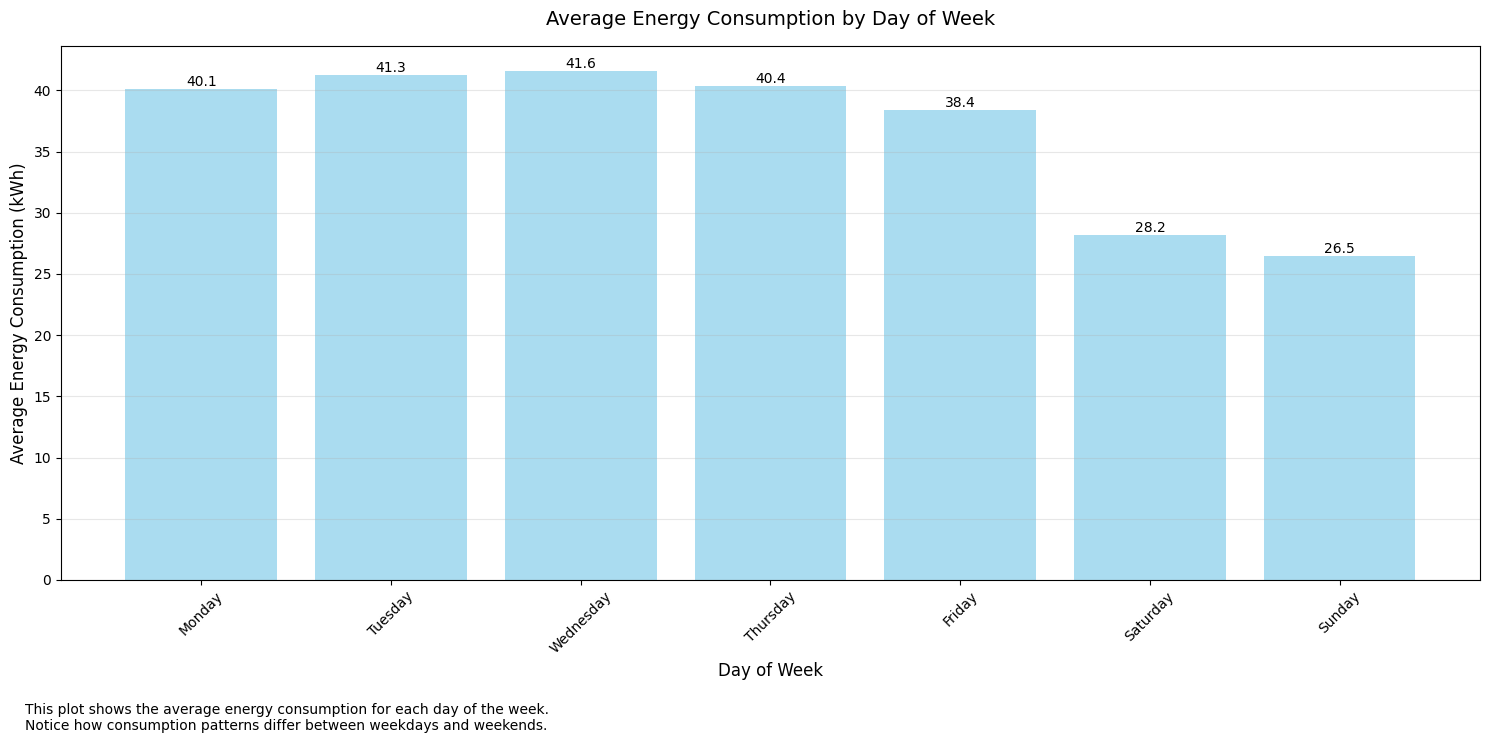

In [8]:
plt.figure(figsize=(15, 7))

daily_consumption = train_data.groupby('day_of_week')['EnergyConsumption(kWh)'].mean()

# Create bar plot
bars = plt.bar(daily_consumption.index, daily_consumption.values, 
               color='skyblue', alpha=0.7)

# Customize the plot
plt.title('Average Energy Consumption by Day of Week', fontsize=14, pad=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Customize x-axis labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), days, rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Add a brief explanation
plt.figtext(0.02, -0.05, 
            'This plot shows the average energy consumption for each day of the week.\nNotice how consumption patterns differ between weekdays and weekends.',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

#### 1.4.4. Mounthly Trends

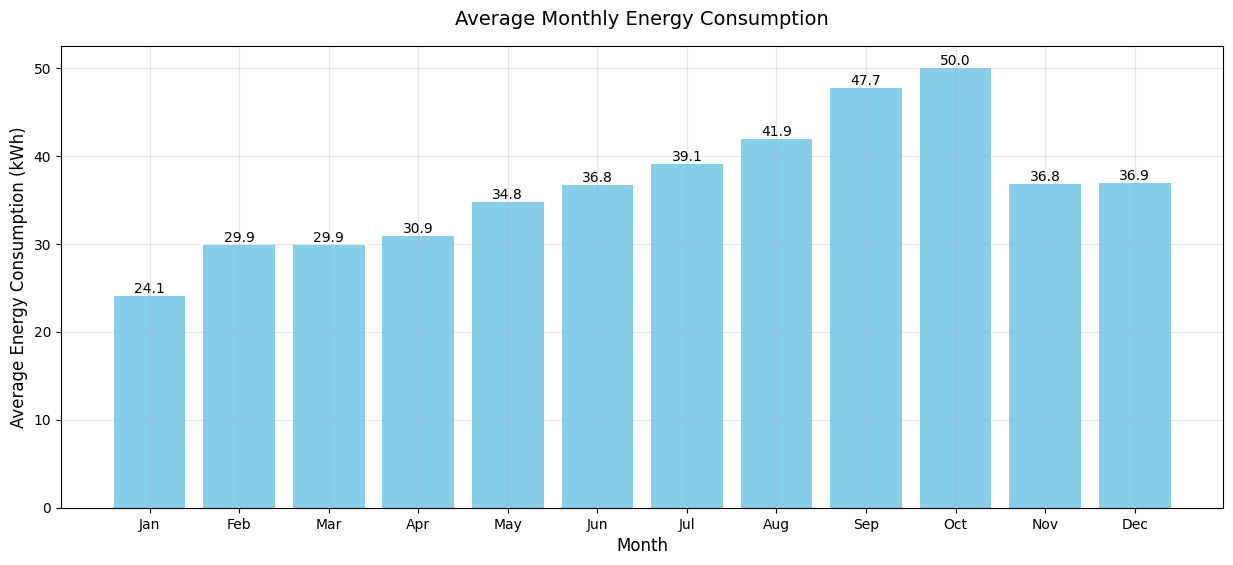

In [9]:
plt.figure(figsize=(15, 6))

# Calculate monthly averages
monthly_avg = train_data.groupby('month')['EnergyConsumption(kWh)'].mean()

# Create seasonal plot
bars = plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue')
plt.title('Average Monthly Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### 1.4.5. Time Series Plot

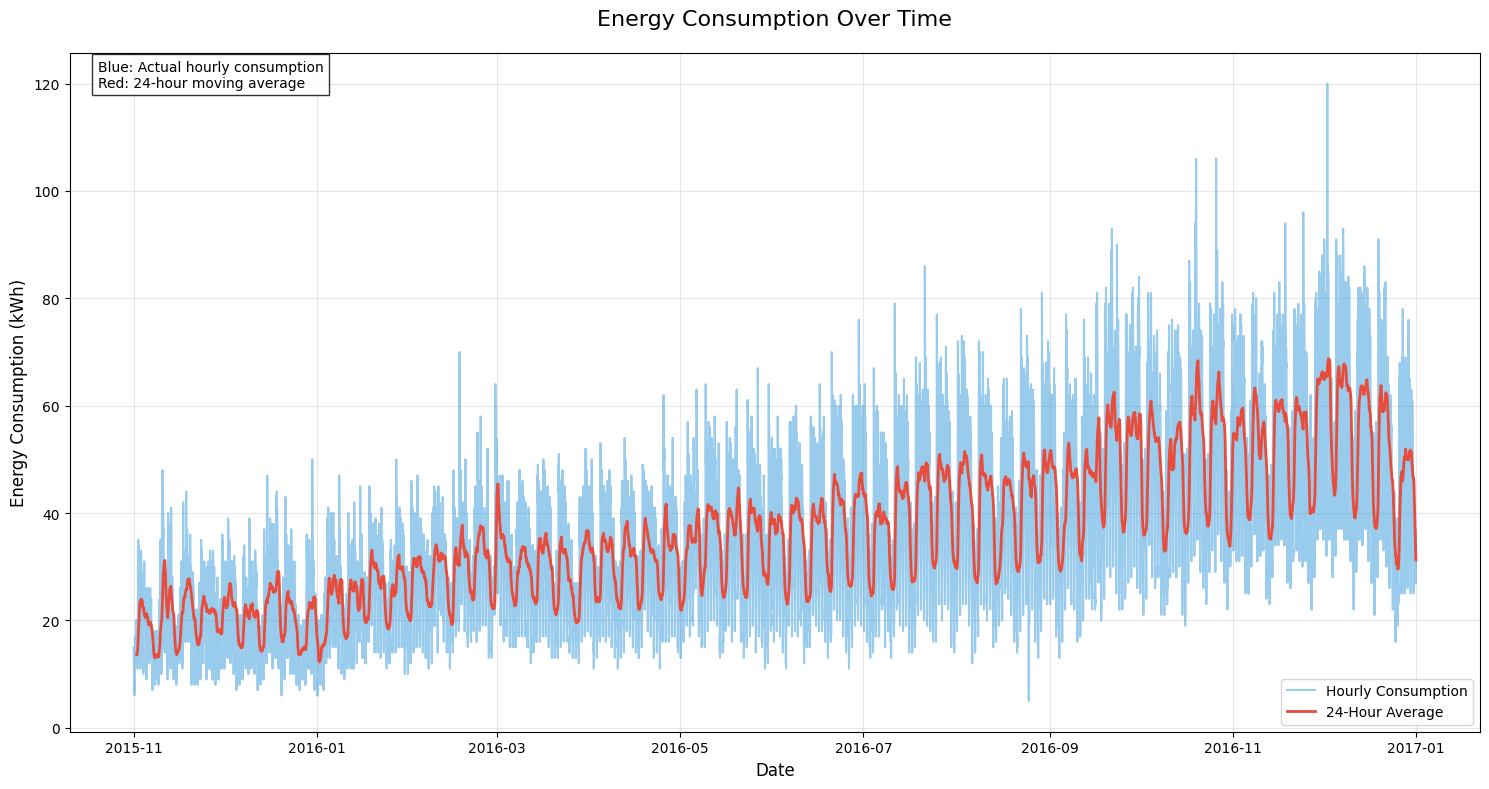

In [10]:
plt.figure(figsize=(15, 8))

plt.plot(train_data['DateTime'], train_data['EnergyConsumption(kWh)'],
         color='#3498db', alpha=0.5, label='Hourly Consumption')

# Add rolling average
window_size = 24  # 24 hours
rolling_avg = train_data['EnergyConsumption(kWh)'].rolling(window=window_size).mean()
plt.plot(train_data['DateTime'], rolling_avg,
         color='#e74c3c', linewidth=2, label='24-Hour Average')

# Customize plot
plt.title('Energy Consumption Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations
plt.annotate('Blue: Actual hourly consumption\nRed: 24-hour moving average',
            xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 1.5. Correlation with Target Variable
The correlation between the target variable and the feature variables is an essential aspect of feature selection.
- **Positive Correlation**: If the correlation between the target variable and a feature variable is positive,
- **Negative Correlation**: If the correlation between the target variable and a feature variable is negative,
- **No Correlation**: If the correlation between the target variable and a feature variable is zero.

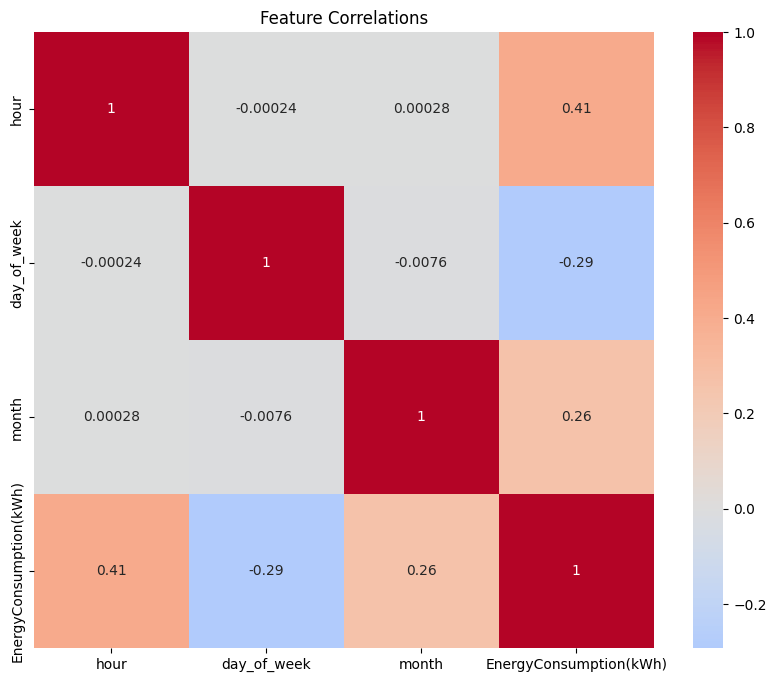

In [11]:
# Cell 10: Correlation Analysis
# Calculate correlations
correlation_matrix = train_data[['hour', 'day_of_week', 'month', 'EnergyConsumption(kWh)']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()


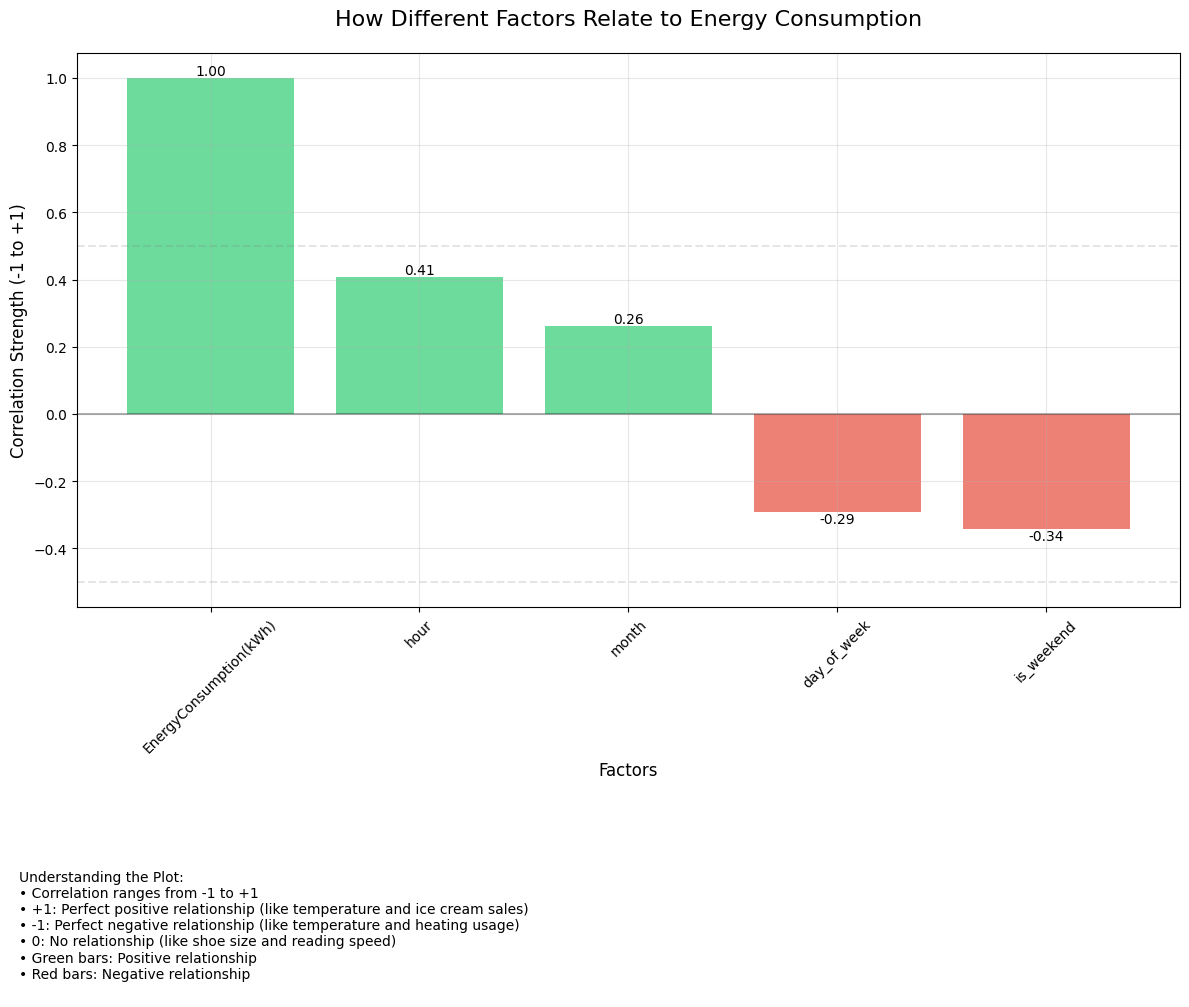

In [12]:
# Create figure
plt.figure(figsize=(12, 8))

# Calculate correlations with target
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'EnergyConsumption(kWh)']
correlation_matrix = train_data[features].corr()['EnergyConsumption(kWh)'].sort_values(ascending=False)

# Create bar plot
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in correlation_matrix]
bars = plt.bar(range(len(correlation_matrix)), 
               correlation_matrix,
               color=colors,
               alpha=0.7)

# Customize appearance
plt.title('How Different Factors Relate to Energy Consumption', fontsize=16, pad=20)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Correlation Strength (-1 to +1)', fontsize=12)

# Add feature labels
plt.xticks(range(len(correlation_matrix)), 
           correlation_matrix.index,
           rotation=45)

# Add correlation values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{height:.2f}',
             ha='center', 
             va='bottom' if height >= 0 else 'top')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.2)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.2)

# Add explanation box
explanation_text = '''
Understanding the Plot:
• Correlation ranges from -1 to +1
• +1: Perfect positive relationship (like temperature and ice cream sales)
• -1: Perfect negative relationship (like temperature and heating usage)
• 0: No relationship (like shoe size and reading speed)
• Green bars: Positive relationship
• Red bars: Negative relationship
'''

plt.figtext(0.02, -0.25, explanation_text, fontsize=10, ha='left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
# Print numerical interpretation
print("\nRelationship Strength Summary:")
for feature, corr in correlation_matrix.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"• When {feature} goes up, energy consumption tends to {direction} ({strength} relationship: {corr:.2f})")


Relationship Strength Summary:
• When EnergyConsumption(kWh) goes up, energy consumption tends to increases (strong relationship: 1.00)
• When hour goes up, energy consumption tends to increases (moderate relationship: 0.41)
• When month goes up, energy consumption tends to increases (weak relationship: 0.26)
• When day_of_week goes up, energy consumption tends to decreases (weak relationship: -0.29)
• When is_weekend goes up, energy consumption tends to decreases (moderate relationship: -0.34)


### 1.6. Time Series Decomposition
- Time series decomposition is a technique used to break down a time series into its underlying components. This can
include trend, seasonality, and residuals. The goal of decomposition is to identify the underlying patterns and
trends in the data, which can be useful for forecasting and other applications.

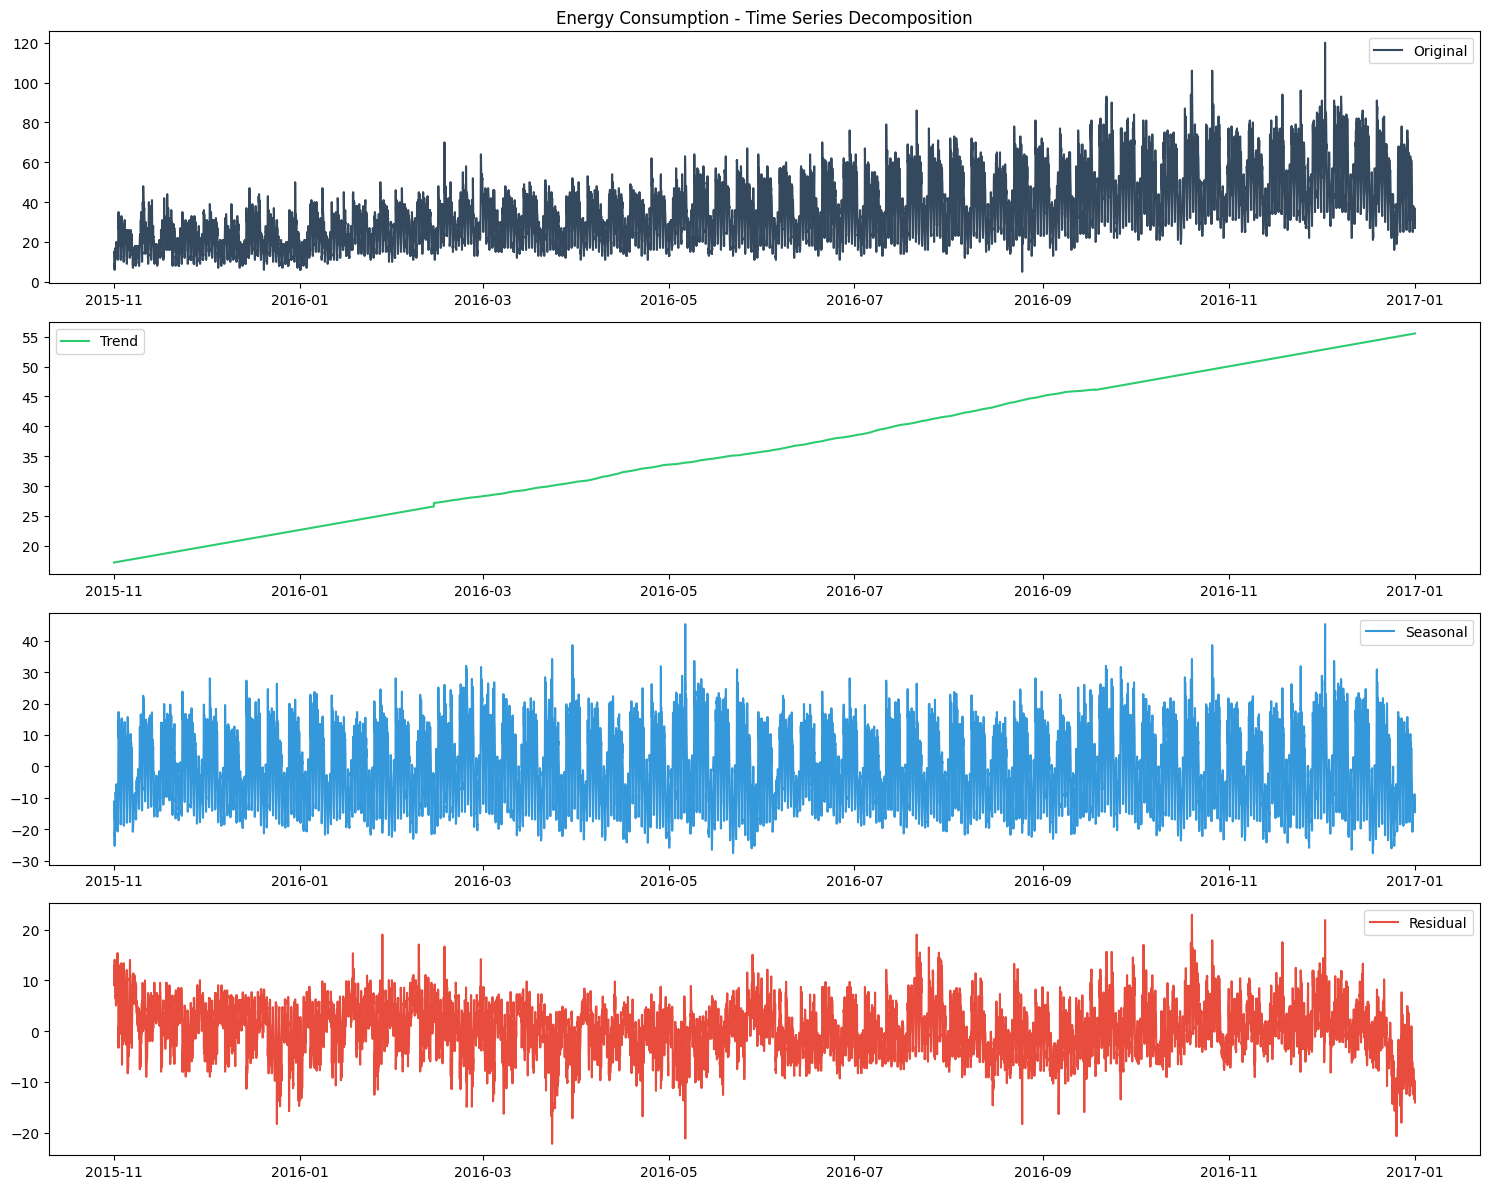

In [23]:
# Prepare time series data
ts_data = train_data.set_index('DateTime')['EnergyConsumption(kWh)']

# Decompose series
decomposition = seasonal_decompose(ts_data, 
                                 period=24*7*30,  # Mounthly seasonality
                                 extrapolate_trend='freq')

# Visualize components
plt.figure(figsize=(15, 12))

# Plot components
components = ['Original', 'Trend', 'Seasonal', 'Residual']
data = [ts_data, decomposition.trend, 
        decomposition.seasonal, decomposition.resid]
colors = ['#34495e', '#2ecc71', '#3498db', '#e74c3c']

for idx, (title, data, color) in enumerate(zip(components, data, colors), 1):
    plt.subplot(4, 1, idx)
    plt.plot(data, color=color, label=title)
    plt.legend()
    if idx == 1:
        plt.title('Energy Consumption - Time Series Decomposition')

plt.tight_layout()
plt.show()

### 1.7. Augmented Dickey-Fuller Test

In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
result = adfuller(train_data['EnergyConsumption(kWh)'])

# Extract and print test results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Check the p-value
if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF Statistic: -6.999014953590991
p-value: 7.404661154831535e-10
Critical Values:
   1%: -3.4309905782661114
   5%: -2.861823098132885
   10%: -2.5669206879928983
The series is stationary.


### 1.8. ACF and PACF for best ARIMA parameters

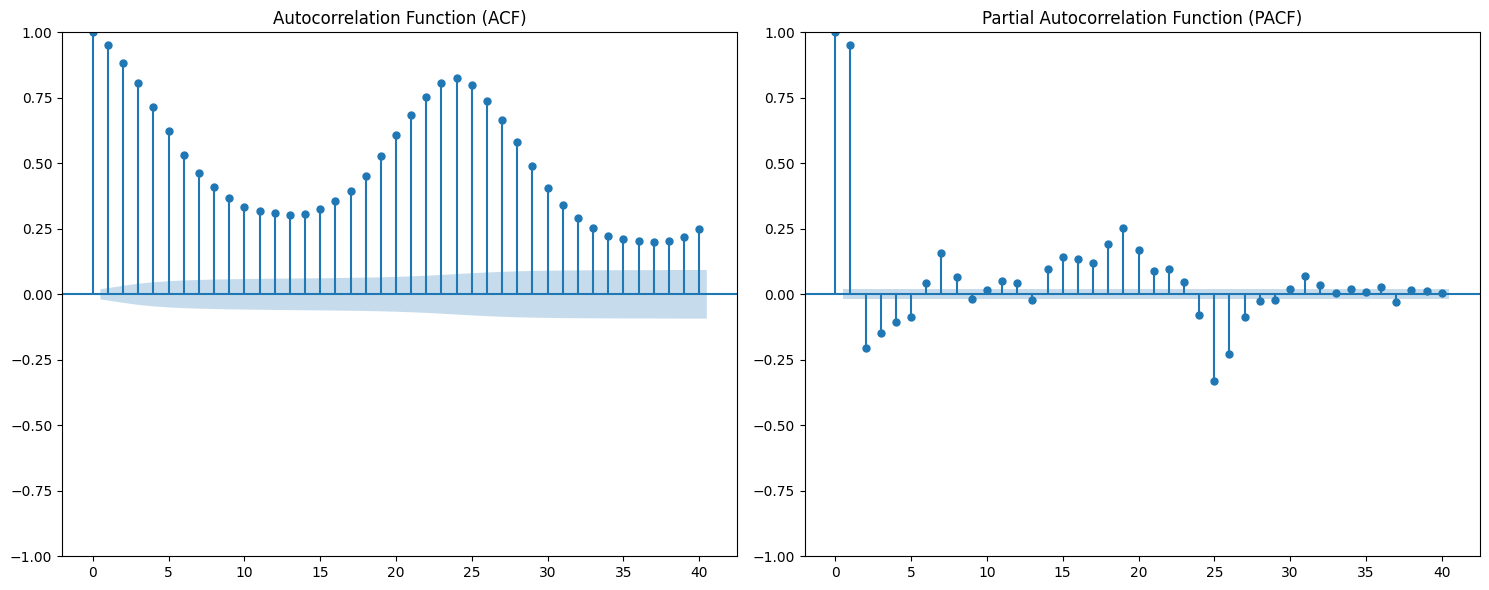

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(15, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(train_data['EnergyConsumption(kWh)'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(train_data['EnergyConsumption(kWh)'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# ARIMA PARAMETERS (p=2, d=0, q=3)

### 1.9. Fourier Tranform

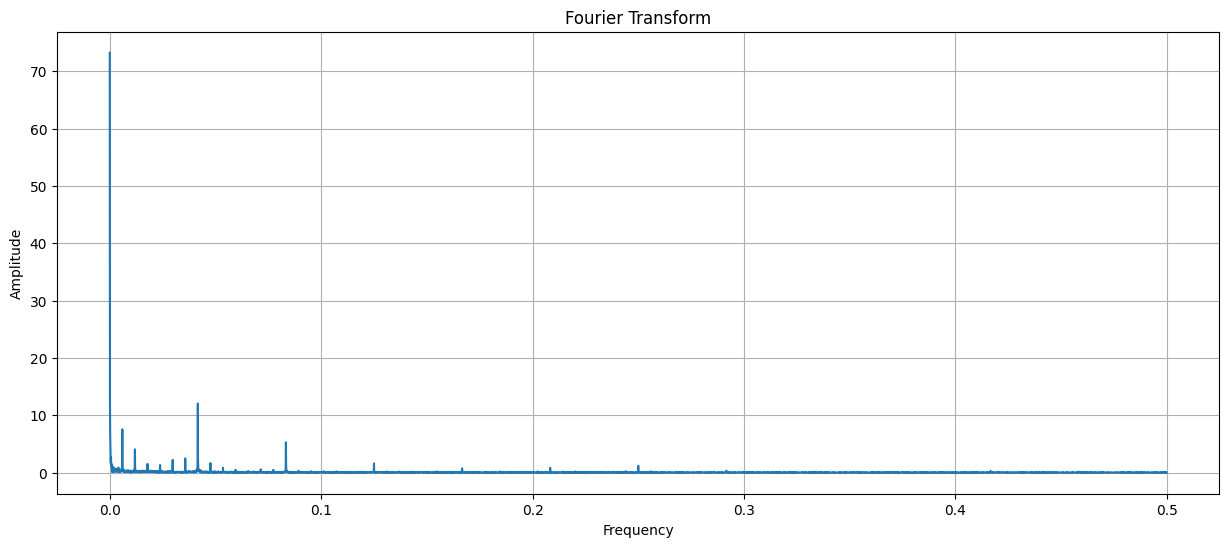

In [25]:
from scipy.fft import fft, fftfreq
import numpy as np

# Prepare time series data
ts_data = train_data.set_index('DateTime')['EnergyConsumption(kWh)']

# Perform Fourier Transform
N = len(ts_data)
T = 1.0  # Assuming hourly data
yf = fft(ts_data)
xf = fftfreq(N, T)[:N//2]

# Plot the Fourier Transform
plt.figure(figsize=(15, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()